<a href="https://colab.research.google.com/github/prathwishshetty/causalML/blob/causalDSBoston/Causal_Data_Science_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Causal Data Science Analysis of Airbnb Listings**

# Project Setup

The following packages are the requirements for this notebook.

* `herepy`
* `xmltodict`
* `rpy2`
* `pgmpy`
* `bnlearn`
* `torch`
* `pyro`  


They can be installed with the following commands on Google Colab or a Jupyter Notebook,

```
!pip install herepy
!pip install xmltodict  
!pip install rpy2  
!pip install pgmpy 
!pip install bnlearn
!pip install torch torchvision  
!pip install pyro-ppl
```

In [0]:
#@title Import libraries
import pandas as pd
import herepy
from tqdm.notebook import tqdm
from collections import defaultdict
import re
import requests
import urllib
import xmltodict
import json
import numpy as np
#packages for R in python
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
#CPD
from pgmpy.models import BayesianModel
#bnlearn
import bnlearn
import torch
import pyro
import pyro.distributions as dist
from statistics import mean
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Image

%matplotlib inline

# Overview

The goal of this causal data science project was to determine the causal effects of various factors on return on investment from a property listed on Airbnb.



# Objective

The objectives for this analysis is as follows:
* Build a causal DAG
* Collect the required data for the analysis
* Build a causal model and train it on the data
* Use the model to make causal inferences
* Use the model to determine the return on investments of listed properties


# Initial DAG


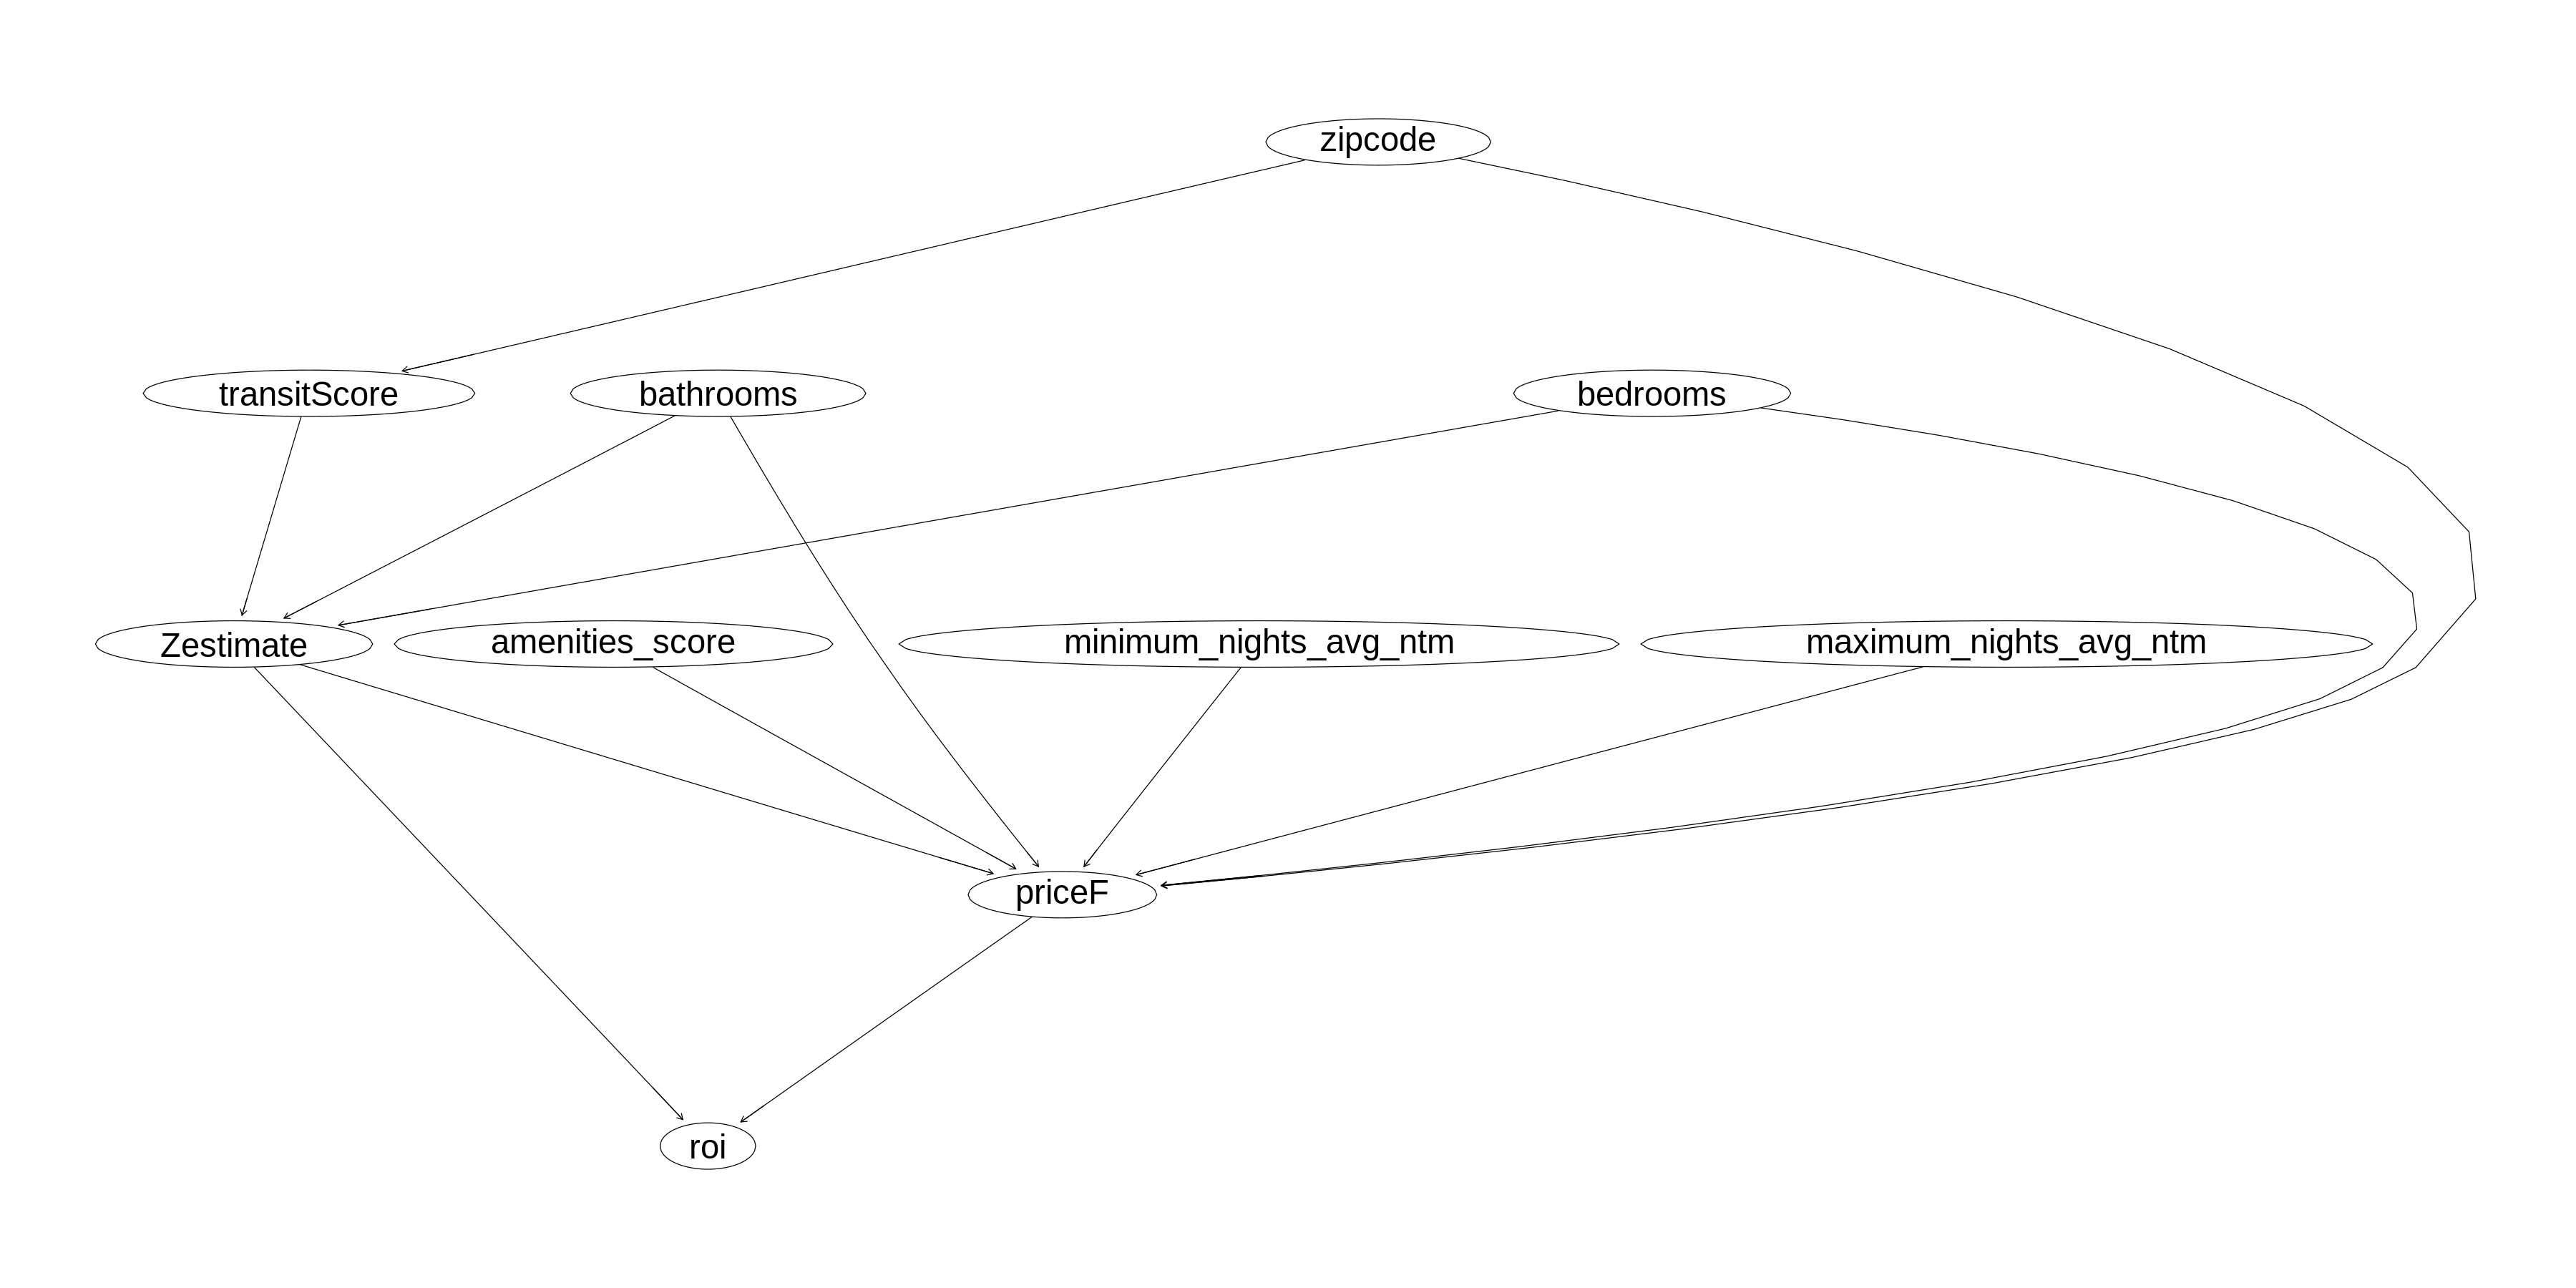

In [0]:
Image(filename='images/dag1.png')

### The results of Global Markov property and faithfulness asumptions:
1. the number of arg_sets we obtained with this dag: 7335

2. The total number of true d-separation: 1385

3. A significance value of <= 0.05 was taken for the Conditional Independence Test 

4. Global Markov property: the proportion of true D-separation statements that are also true conditional independence statements is 0.95

5. Faithfulness assumption: the proportion of true conditional independence statements that are also true-deseparation statements 0.19



# Final DAG

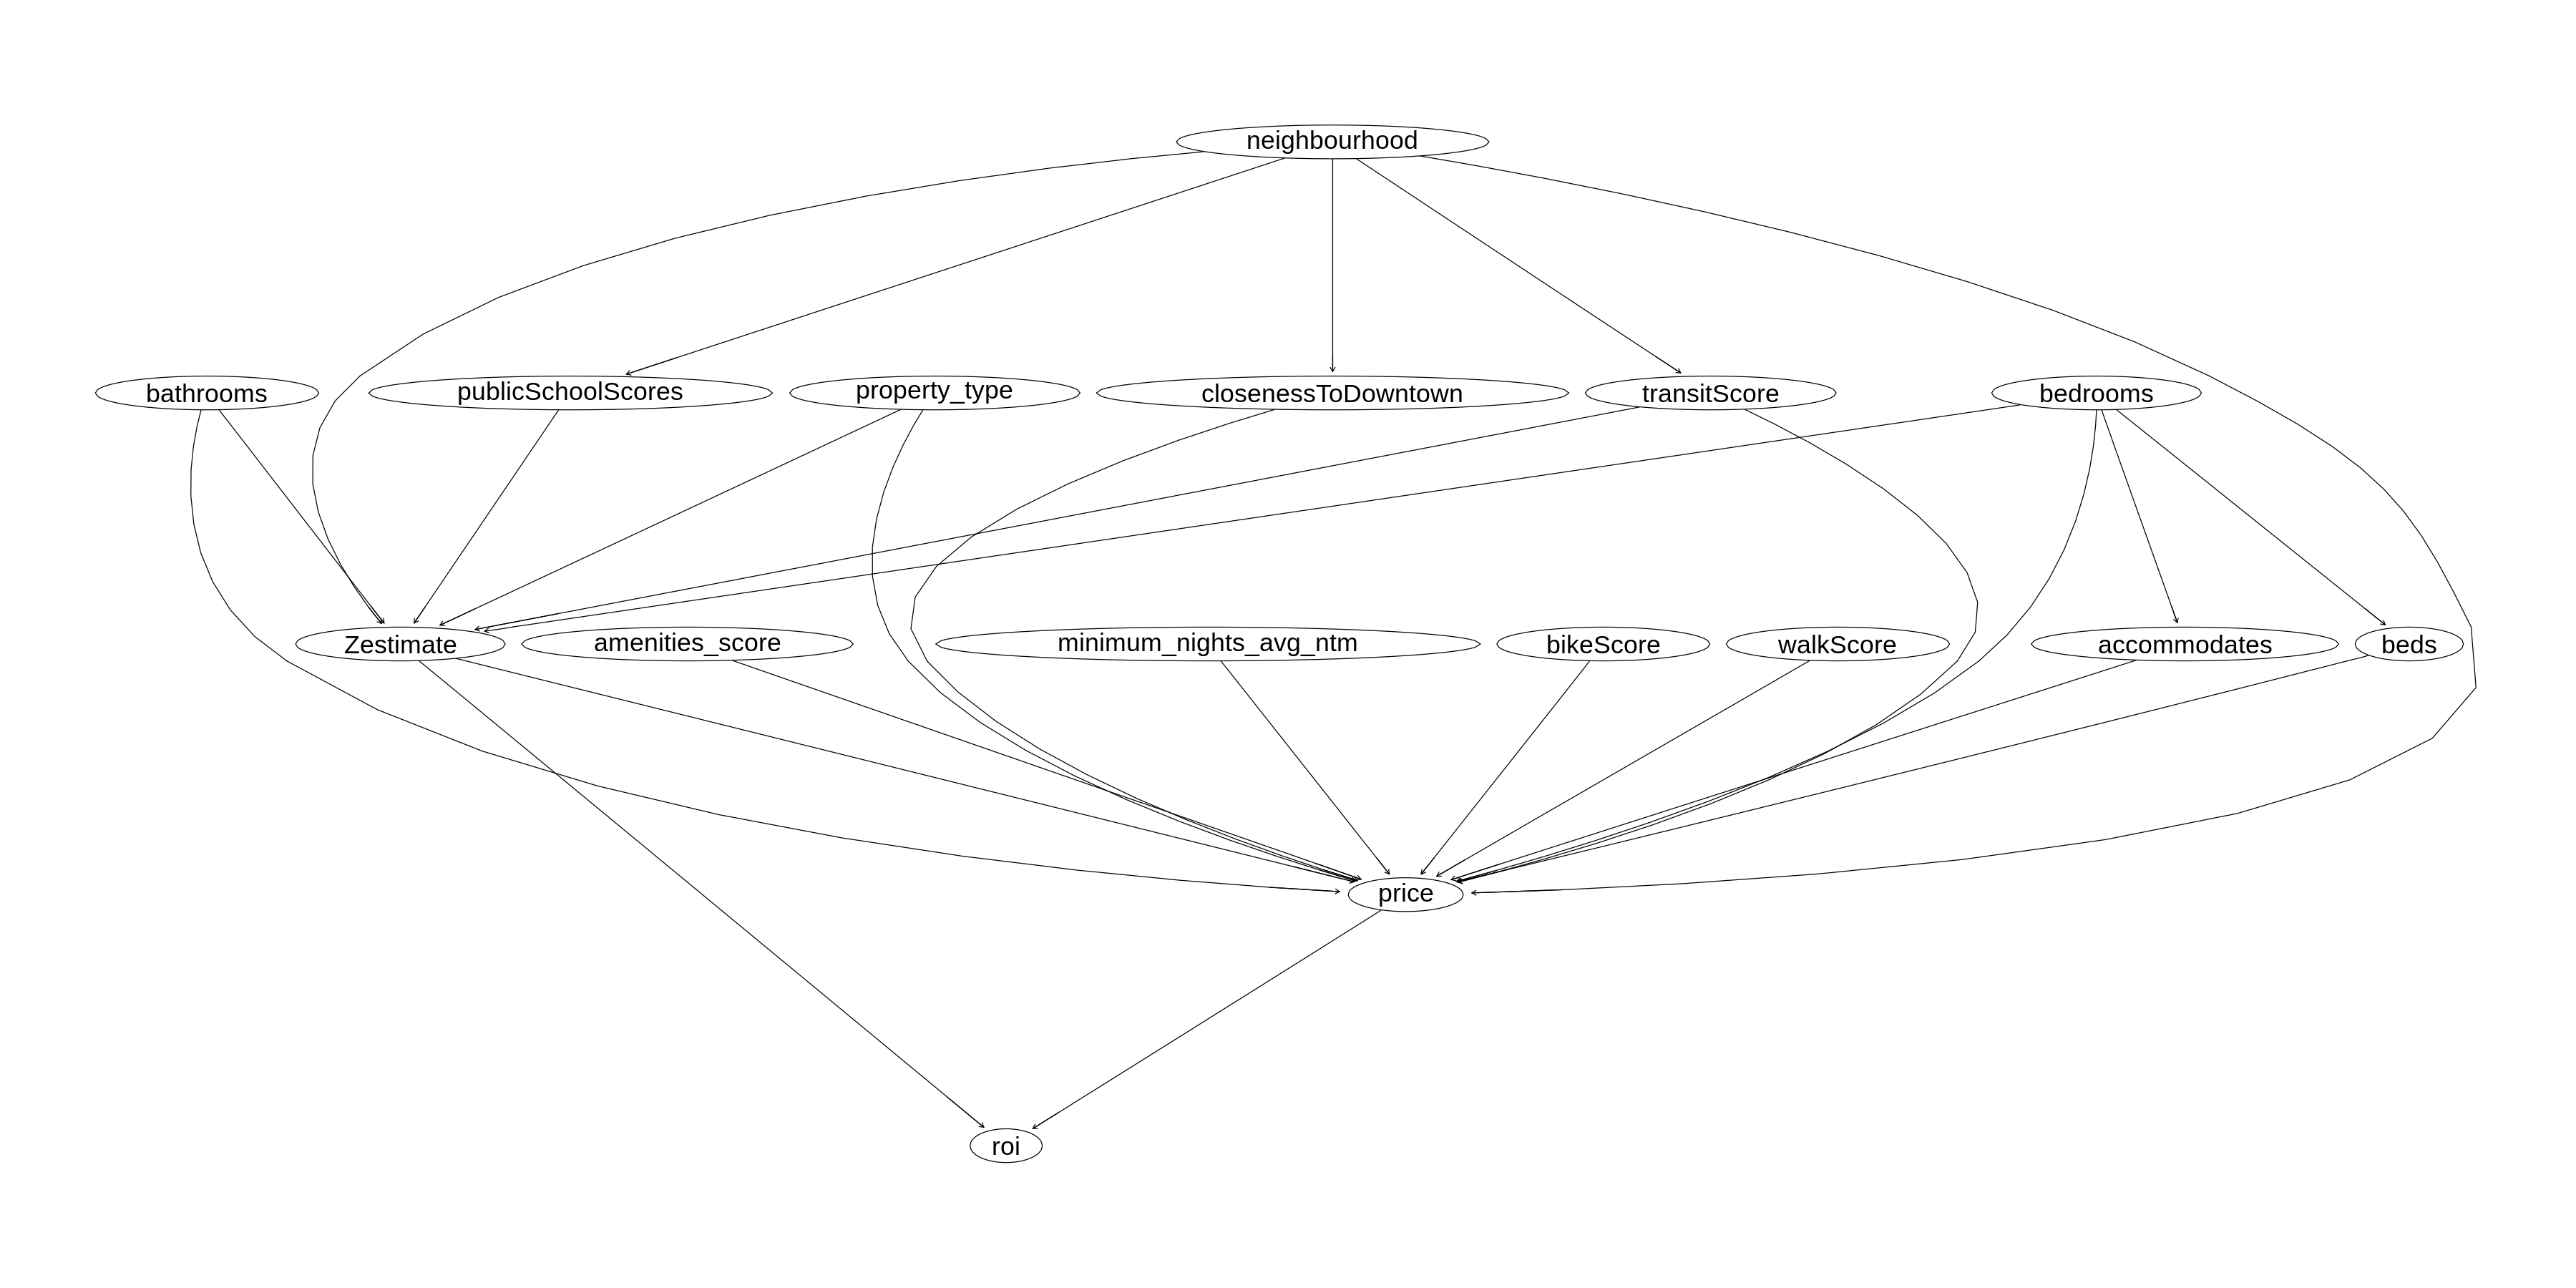

In [0]:
Image(filename='images/dag2.png')

### The results of Global Markov property and faithfulness asumptions:
1. the number of arg_sets we obtained with this dag: 200526

2. the total number of true d-separation: 62048

3. A significance value of <= 0.05 was taken for the Conditional Independence Test

4.  Global Markov property: the proportion of true D-separation statements that are also true conditional independence statements is 0.98

5. Faithfulness assumption: the proportion of true conditional independence statements that are also true-deseparation statements 0.31



# Data

The data we has used is from Airbnb listings data for the [city of boston](http://data.insideairbnb.com/united-states/ma/boston/2020-02-13/data/listings.csv.gz). The data has all the features that one would see on an Airbnb listings page.


What the data lacks is the actual data on the property i.e. market value of the house or even the address of the house.

## Data Preperation

The data for this analysis can be found at 

In [0]:
listings = pd.read_csv('data/listings.csv')

## Filtering dataset

Conditions for filtering

* We select only those listings that have an exact location in their listing. The reason we do this is to get the most accurate value of the property as possible

In [0]:
listings = listings[listings['is_location_exact'] == 't']

* We select only house types `Apartment` and `Condominium`. This was done inorder to prevent outliers i.e. listings like `boats` and `castle`. 

In [0]:
listings = listings[listings['property_type'].isin(['Apartment','Condominium'])]

* We also selected those listings that had the `Entire home or apartment` listed for rent. This was done to weed out listings that only had a single room etc.

In [0]:
listings = listings[listings['room_type']=='Entire home/apt']

* We also wanted to include only those listings that are available for guests and those that are constantly updated to the latest prices in the market. Hence we selected only listing that have been upadted atleast once in the last 12 months.

In [0]:
listings = listings[listings['calendar_updated'].isin(['today','yesterday','2 days ago',
                                                       '3 days ago','4 days ago','5 days ago',
                                                       '6 days ago','a week ago','1 week ago',
                                                       '2 weeks ago','3 weeks ago','4 weeks ago',
                                                       '5 weeks ago','6 weeks ago','7 weeks ago',
                                                       '2 months ago','3 months ago','4 months ago',
                                                       '5 months ago','6 months ago','7 months ago',
                                                       '8 months ago','9 months ago','10 months ago',
                                                       '11 months ago','12 months ago'])]

* We don't want to include any listings that has not been booked before, this helps out listings that are spam or very recently listed

In [0]:
listings = listings[listings['first_review'].notnull()]

## Data Enrichment

Though the Airbnb dataset is rich with features, it lacks the data on the property related details that is a vital part of this project. Hence we need to enrich this data by using our domain knowledge. 

The first step is finding what is the exact address of each listing. To do this we leveraged the API's from **Here** maps. The below function takes in `longitude` and `latitude` and returns a physical address of the location.

In [0]:
def herePy(latitude,longitude,apiKey):
    address = defaultdict()
    hereAPI   = herepy.GeocoderReverseApi(apiKey)
    response  = hereAPI.retrieve_addresses([latitude,longitude])
    address   = response.Response['View'][0]['Result'][0]['Location']['Address']
    matchLevel= response.Response['View'][0]['Result'][0]['MatchLevel']
   
    return pd.Series([address.get('Label',None),
                      address.get('HouseNumber',None),
                      address.get('Street',None),
                      address.get('Country',None),
                      address.get('PostalCode',None),
                      matchLevel],
                     index=['Address','HouseNumber','Street','Country',
                            'PostalCode','matchLevel'])



In [0]:
hereMapsAPI = #enter API
herePy('42.3547464','-71.0740765',hereMapsAPI)

Address        135 Beacon St, Boston, MA 02116, United States
HouseNumber                                               135
Street                                              Beacon St
Country                                                   USA
PostalCode                                              02116
matchLevel                                        houseNumber
dtype: object

Now we get address for all the listings

In [0]:
tqdm.pandas()
listings[['Address','HouseNumber','Street','Country','PostalCode','matchLevel']] = listings.progress_apply(lambda row: herePy(row['latitude'], row['longitude'], hereMapsAPI) , axis=1)

### Get Estimates of each listing

#### Automated Webscraping

Initially we tried to get the Estimate of each property by automatically scrapping Property listing websites like Redfin and Zillow. Unfortunately, Zillow has deprecated is public use API for a commercial only API which does not allow its data to be used for a derivative model.

Next, we tried writing a script to scarpe data from Redfin.com, we were able to get results but the accuracy of those results were questionable owing to the fact that, all we had was an approximate address. Hence we come to the conclusion that human insight was vital for the data to be accurate.

![](images/redfinScrapping.gif)
![](https://drive.google.com/uc?export=view&id=1Bs-sOLpfWYkez3vpc_597719FRye4oDQ)

#### Manual Webscrapping

After we were unable to automate the we went ahead and manual scoured the internet for the most accurate listing price we could find. We collected values for 200 listings.

In [0]:
lisiting_manual = pd.read_csv('data/listings_manual.csv')

In [0]:
listings_full   = lisiting_manual.merge(listings,on='id')

In [0]:
no_unique_columns = [x for y,x in enumerate(listings_full.columns) if len(set(list(listings_full[x])))==1]
listings_full = listings_full.drop(columns=no_unique_columns).reset_index(drop=True)

#### Calculating monthly mortage rate

We calculate the fixed monthly mortgage rate by using compounding interest method by taking interest rate of [4%]() annual, for a 15 year mortgage payment plan and a downpayment of 20%.


In [0]:
i = (0.04/12)   # Interest rate divided by 12
dr = 0.80       # Principal for mortgage
n  = 15*12      # 15 years mortgage
multiplier = (i*((1+i)**n))/(((1+i)**n)-1) # compound interest formula
listings_full['mortgage_p_month'] = (listings_full['Zestimate'].astype(float)*multiplier*dr).astype(int)

Annual Tax Rate 

The average annual tax rate for boston is around 0.804%

In [0]:
listings_full['annual_tax']  = (listings_full['Zestimate'].astype(float)*0.00804).astype(int)

#### Insurance per month

The average insuracnce per month in boston is around [0.035%](https://www.zillow.com/mortgage-learning/homeowners-insurance/) of the property value

In [0]:
listings_full['ins_p_month'] = (listings_full['Zestimate'].astype(float)*0.00035).astype(int)

#### ROI for the 1st year

Return on investment measures how much money or [profit](https://www.investopedia.com/terms/p/profit.asp)
 is made on an investment as a percentage of the cost of that investment. It shows how effectively and efficiently investment dollars are being used to generate profits. Knowing ROI allows investors to assess whether putting money into a particular investment is a wise choice or not.

In [0]:
listings_full['ins_p_month'] = (listings_full['Zestimate'].astype(float)*0.00035).astype(int)

In [0]:
listings_full['price'] = listings_full['price'].str.replace('$','')
listings_full['price'] = listings_full['price'].str.replace(',','').astype(float)

In [0]:
listings_full['roi'] = (listings_full['price']*340 - ((listings_full['mortgage_p_month']+ listings_full['ins_p_month'])*12 + listings_full['mortgage_p_month']))/(0.2*listings_full['Zestimate'].astype(float))*100

### Connectivity of the property


We decided that its important for us to know how well the property is connected to available modes of transport.

The three modes we were interested in was bike, transit and walking. We got this data from [walkscore.com](https://www.walkscore.com/methodology.shtml), which uses patented measures to get the scores.



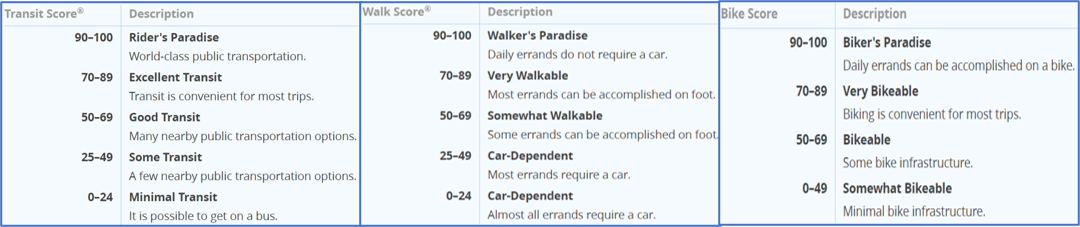

In [0]:
Image(filename='images/walkScores.png')

In [0]:
# Function to query `walkscore.com` to get the score for walking, transit and biking score
def walkScore(address,lat,lon,api,transit=1,bike=1):
    add  = re.sub('\s', '%', address)
    latitude = "&lat="+str(lat)
    longitude= "&lon="+str(lon)
    tran_code= "&transit="+str(transit)
    bike_code= "&bike="+str(bike)
    api_key  = "&wsapikey="+api
    api_url  = "http://api.walkscore.com/score?format=json&address="
    r = requests.get(api_url+add+latitude+longitude+tran_code+bike_code+api_key).json()
    walkScore = r['walkscore']
    bikeScore = r['bike']['score']
    trasitScore = r['transit']['score']
    return pd.Series([walkScore,bikeScore,trasitScore],index=['walkScore','bikeScore','transitScore'])

In [0]:
walkscoreAPI = #get API from walkscore.com
tqdm.pandas()
listings_full[['walkScore','bikeScore','transitScore']] = listings_full.progress_apply(lambda row: walkScore(row['Address'],row['latitude'], row['longitude'],api=walkscoreAPI) , axis=1)

In [0]:
listings_full['walkScore']    = pd.cut(listings_full.walkScore.astype(int),bins=[0,24,49,69,89,100],labels=['1','2','3','4','5'])
listings_full['transitScore'] = pd.cut(listings_full.transitScore.astype(int),bins=[0,24,49,69,89,100],labels=['1','2','3','4','5'])
listings_full['bikeScore']    = pd.cut(listings_full.bikeScore.astype(int),bins=[0,49,69,89,100],labels=['1','2','3','4'])

In [0]:
listings_full['walkScore']    = listings_full['walkScore'].cat.remove_unused_categories()
listings_full['transitScore'] = listings_full['transitScore'].cat.remove_unused_categories()
listings_full['bikeScore'] = listings_full['bikeScore'].cat.remove_unused_categories()

### Amenities

Amenities offered by the building are an important foctor that decides the cost of the house for a buyer and the amenities offered by the host play an important role for a guest when renting out an AirBnb.

In the listings dataset from Airbnb, we have all the amenities offered by the host to the guest, there are a total of 100 different amenities offered by the hosts to guests. We have decided to score an individual listing by checking how many amenities do they offer out of the 100 possible amenities.

In [0]:
listings_full['amenities_score'] = listings_full['amenities'].apply(lambda x: len(x.split(','))).astype(float)

### Closeness to Down town

We believe the closeness to the downtown of Boston is an important factor that determines if a property is going to perform well on AirBnb listings.

To get the distance of each property from downtown we again use the Here Maps api, this time we use the Routing API to get our Distances.

We consider the distance from each property to Downtown Crossing(42.355754,-71.0602654), the distance here is in meters.

In [0]:
def getclosenessToDT(lat, lon,hereMapsAPI):
    routingApi = herepy.RoutingApi(hereMapsAPI)
    response = routingApi.car_route([lat, lon],
                                [42.355549, -71.060379],
                                [herepy.RouteMode.car, herepy.RouteMode.fastest])
    distance = [x['summary']['distance'] for x  in response.response['route']][0]
    return pd.Series([distance],index=['closenessToDowntown'])

In [0]:
hereMapsAPI = '0T-4r625gRiV-xGAilmWXDvgQoOGiXovzv4s6UVsQoI'
listings_full[['closenessToDowntown']] = listings_full.progress_apply(lambda row: getclosenessToDT(row['latitude'], row['longitude'],hereMapsAPI) , axis=1)

### Quality of public schools nearby

We believe that the quality of the public schools nearby determines the price of a property and also on individuals decision to buy a property.

Hence we decided to collect the information on the quality of public schools in within a 2 mile radius of the house. To get this rating we collected a list of all the public schools within the 2 mile radius and their repective rating from [greatschools.org](https://www.greatschools.org/) and then took the average.

We used an API from great schools to get the scores

In [0]:
def schoolsNearMe(lat,lon,radius,greatSchoolsAPi):
    url_base  = "https://api.greatschools.org/schools/nearby?key="
    api       = greatSchoolsAPi+"&state=MA"
    lat_url   = "&lat="+str(lat)
    lon_url   = "&lon="+str(lon)
    radius_url= "&radius="+str(radius)

    url       =  url_base+api+lat_url+lon_url+radius_url

    contents = urllib.request.urlopen(url).read()
    my_dict=xmltodict.parse(contents)
    json_data=json.dumps(my_dict)
    json_data2 = json.loads(json_data)
    
    lister = [int(x['gsRating']) for x in json_data2['schools']['school'] if 'gsRating' in x.keys()]

    score = sum(lister)/len(lister)
    return pd.Series([score],index=['publicSchoolScores '])

In [0]:
greatSchoolsAPi= #Enter API
listings_full[['publicSchoolScores']] = listings_full.progress_apply(lambda row: schoolsNearMe(row['latitude'], row['longitude'],radius=2,greatSchoolsAPi) , axis=1)

**Note:** If the api's are deprecated or the if you are unable to access the api, the feature rich data can be found in the file,`listings_full.csv`

In [0]:
# Run if you are unable to generate the data from the above steps for what so ever reasons
listings_full = pd.read_csv('data/listings_full.csv')

### Filtering out columns we need

In [0]:
listings_subset = listings_full[['id','Zestimate','bedrooms','bathrooms','beds','accommodates','amenities_score',
               'bikeScore','walkScore','transitScore','neighbourhood_cleansed','property_type',
               'publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm','roi']]

In [0]:
pd.options.mode.chained_assignment = None 
listings_subset['property_type'] = listings_subset['property_type'].astype('category')
listings_subset['bathrooms'] = listings_subset['bathrooms'].astype('category')
listings_subset['neighbourhood'] = listings_subset['neighbourhood_cleansed'].astype('category')
del listings_subset['neighbourhood_cleansed']

listings_subset['roi'] = listings_subset['roi'].astype('float')
listings_subset['Zestimate'] = listings_subset['Zestimate'].astype('float')
listings_subset['bedrooms'] = listings_subset['bedrooms'].astype('float')
listings_subset['beds'] = listings_subset['beds'].astype('float')
listings_subset['accommodates'] = listings_subset['accommodates'].astype('float')
listings_subset['amenities_score'] = listings_subset['amenities_score'].astype('float')
listings_subset['publicSchoolScores'] = listings_subset['publicSchoolScores'].astype('float')
listings_subset['closenessToDowntown'] = listings_subset['closenessToDowntown'].astype('float')
listings_subset['price'] = listings_subset['price'].astype('float')
listings_subset['minimum_nights_avg_ntm'] = listings_subset['minimum_nights_avg_ntm'].astype('float')
pd.options.mode.chained_assignment = 'warn'

In [0]:
listing_cat = listings_subset[['bathrooms','bikeScore','walkScore','transitScore','property_type','neighbourhood']]

In [0]:
listings_n_cat = listings_subset[['roi','Zestimate','bedrooms','beds','accommodates','amenities_score','publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm']]

## Discretizing the columns to be used in the model using hartemink

In [0]:
def rDiscretize(data):
    utils = importr('utils')
    utils.install_packages('bnlearn')
    # utils.install_packages('base')
    bnlearnR = importr('bnlearn')
    bnDiscretize = bnlearnR.discretize
    # Import Functions
    pandas2ri.activate()
    r_dt = ro.conversion.py2rpy(data) #convert pandas to RDataframe
    r_dt2 = bnDiscretize(r_dt,method= "hartemink", breaks = 3, ibreaks=3)
    pd_dt = ro.conversion.rpy2py(r_dt2)
    pd_dt.reset_index(drop=True)
    return pd_dt

In [0]:
%%capture
listings_fac = rDiscretize(listings_n_cat)

In [0]:
data_discrete = listings_fac.reset_index(drop=True).join(listing_cat)

# Building a DAG in python

In [0]:
nodes = ['amenities_score','bathrooms','bedrooms','transitScore','Zestimate','neighbourhood',
         'roi','price','minimum_nights_avg_ntm','bikeScore','walkScore','publicSchoolScores',
         'property_type','closenessToDowntown','accommodates','beds']

In [0]:
edges = [('amenities_score','price'),
         ('bathrooms','price'),
         ('bathrooms','Zestimate'),
         ('bedrooms','price'),
         ('bedrooms','beds'),
         ('bedrooms','accommodates'),
         ('bedrooms','Zestimate'),
         ('property_type','price'),
         ('property_type','Zestimate'),
         ('price','roi'),
         ('transitScore','Zestimate'),
         ('transitScore','price'),
         ('Zestimate', 'price'),
         ('Zestimate','roi'),
         ('bikeScore','price'),
         ('walkScore','price'),
         ('beds','price'),
         ('accommodates','price'),
         ('neighbourhood','price'),
         ('neighbourhood','transitScore'),
         ('neighbourhood','publicSchoolScores'),
         ('publicSchoolScores','Zestimate'),
         ('neighbourhood','Zestimate'),
         ('neighbourhood','closenessToDowntown'),
         ('closenessToDowntown','price'),                    
         ('minimum_nights_avg_ntm','price')]

In [0]:
from pgmpy.models import BayesianModel
graph = BayesianModel()

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

In [0]:
def adjacencyMatrix(edges):
    df = pd.DataFrame(edges, columns =['source','target'], dtype = float) 
    df = pd.crosstab(df.source, df.target)
    idx = df.columns.union(df.index)
    df2 = df.reindex(index = idx, columns=idx, fill_value=0)
    df2.index.name = "source"
    df2 = df2.rename_axis('target')
    return df2

In [0]:
adjMat = adjacencyMatrix(edges)

In [0]:
data_discrete = data_discrete.astype(object)

In [0]:
model ={'adjmat':adjMat,
        'model':graph}

model_update = bnlearn.parameter_learning.fit(model, data_discrete, verbose=1)

In [0]:
labels ={}
for i in list(model_update['model'].nodes):
    labels[i] = model_update['model'].get_cpds(i).state_names[i]

# Transfer Model to Pyro

In [0]:
params_amenities_score          = torch.tensor(model_update['model'].get_cpds('amenities_score').values.T)
params_bathrooms                = torch.tensor(model_update['model'].get_cpds('bathrooms').values.T)
params_bedrooms                 = torch.tensor(model_update['model'].get_cpds('bedrooms').values.T)
params_minimum_nights_avg_ntm   = torch.tensor(model_update['model'].get_cpds('minimum_nights_avg_ntm').values.T)
params_bikeScore                = torch.tensor(model_update['model'].get_cpds('bikeScore').values.T)
params_walkScore                = torch.tensor(model_update['model'].get_cpds('walkScore').values.T)
params_property_type            = torch.tensor(model_update['model'].get_cpds('property_type').values.T)
params_neighbourhood            = torch.tensor(model_update['model'].get_cpds('neighbourhood').values.T)
params_accommodates             = torch.tensor(model_update['model'].get_cpds('accommodates').values.T)
params_beds                     = torch.tensor(model_update['model'].get_cpds('beds').values.T)
params_closenessToDowntown      = torch.tensor(model_update['model'].get_cpds('closenessToDowntown').values.T)
params_transitScore             = torch.tensor(model_update['model'].get_cpds('transitScore').values.T)
params_publicSchoolScores       = torch.tensor(model_update['model'].get_cpds('publicSchoolScores').values.T)
params_Zestimate                = torch.tensor(model_update['model'].get_cpds('Zestimate').values.T)
params_price                    = torch.tensor(model_update['model'].get_cpds('price').values.T)
params_roi                      = torch.tensor(model_update['model'].get_cpds('roi').values.T)

In [0]:
def pyroModel():
    amenities_score         = pyro.sample('amenities_score',        dist.Categorical(params_amenities_score))
    bathrooms               = pyro.sample('bathrooms',dist.Categorical(params_bathrooms))
    bedrooms                = pyro.sample('bedrooms', dist.Categorical(params_bedrooms))
    minimum_nights_avg_ntm  = pyro.sample('minimum_nights_avg_ntm', dist.Categorical(params_minimum_nights_avg_ntm))
    bikeScore               = pyro.sample('bikeScore',dist.Categorical(params_bikeScore))
    walkScore               = pyro.sample('walkScore',              dist.Categorical(params_walkScore))
    property_type           = pyro.sample('property_type',          dist.Categorical(params_property_type))
    neighbourhood           = pyro.sample('neighbourhood',          dist.Categorical(params_neighbourhood))
    accommodates            = pyro.sample('accommodates',           dist.Categorical(params_accommodates[bedrooms]))
    beds                    = pyro.sample('beds',dist.Categorical(params_beds[bedrooms]))
    closenessToDowntown     = pyro.sample('closenessToDowntown',   dist.Categorical(params_closenessToDowntown[neighbourhood]))
    transitScore            = pyro.sample('transitScore',           dist.Categorical(params_transitScore[neighbourhood]))
    publicSchoolScores      = pyro.sample('publicSchoolScores',     dist.Categorical(params_publicSchoolScores[neighbourhood]))
    Zestimate               = pyro.sample('Zestimate',dist.Categorical(params_Zestimate[transitScore][publicSchoolScores][property_type][neighbourhood][bedrooms][bathrooms]))
    price                   = pyro.sample('price',dist.Categorical(params_price[walkScore][transitScore][property_type][neighbourhood][minimum_nights_avg_ntm][closenessToDowntown][bikeScore][beds][bedrooms][bathrooms][amenities_score][accommodates][Zestimate]))
    roi                     = pyro.sample('roi',dist.Categorical(params_roi[price][Zestimate]))
    return amenities_score,bathrooms,bedrooms,minimum_nights_avg_ntm,bikeScore,walkScore,property_type,neighbourhood,accommodates,beds,closenessToDowntown,transitScore,publicSchoolScores,Zestimate,price,roi

### After the model preparation we wanted to check how ROI would change after the we do some interventions on our data.

1. What would be the probability of ROI being high after intervening on different levels on all the nodes?

In [0]:
#intervention on single node
def UsingDo(data,value):
    intervention_model = pyro.do(pyroModel, data={data: torch.tensor(value)})
    posterior = pyro.infer.Importance(intervention_model, num_samples=5000).run()
    marginal = EmpiricalMarginal(posterior,"roi")
    samples = [marginal().item() for _ in range(1000)]
    
    unique, counts = np.unique(samples, return_counts=True)
    prob = counts[1]/sum(counts)
  
    return(prob)

In [0]:
#conditioning on a single node

def UsingConditional(data,value):
    conditioned_model = pyro.condition(pyroModel, data={data: torch.tensor(value)})
    posterior = pyro.infer.Importance(conditioned_model, num_samples=5000).run()
    marginal = EmpiricalMarginal(posterior,"roi")
    samples = [marginal().item() for _ in range(1000)]
    
    unique, counts = np.unique(samples, return_counts=True)
    prob = counts[1]/sum(counts)
  
    return(prob)

$P(ROI = high| do(bedrooms))$

In [0]:
pyro.set_rng_seed(10)
#Probability of ROI fixing the bedrooms using do operator
for i in range(len(labels['bedrooms'])):
  val = UsingDo('bedrooms', i)
  print(labels['bedrooms'][i],':',val)

(1,2] : 0.356
(2,6] : 0.349
[0,1] : 0.341


*Inference:*  
We can see from the above results that the ROI is higher on properties with lesser number of bedrooms. And we believe this could be due to the higher price of the properties with more bedrooms.

$P(ROI = high| bedrooms)$

In [0]:
pyro.set_rng_seed(10)
for i in range(len(labels['bedrooms'])):
  val = UsingConditional('bedrooms', i)
  print(labels['bedrooms'][i],':',val)

(1,2] : 0.324
(2,6] : 0.327
[0,1] : 0.329


*Inference:* 
In reality, the studio apartment and aprtment with one bedroom gave the highest ROI. They are generally cheaper in terms of zestimate and also the price/night is also affordable.

$P(ROI = high| do (bathrooms))$

In [0]:
#Probability of ROI fixing the bathrooms using do
pyro.set_rng_seed(10)
for i in range(len(labels['bathrooms'])):
  val = UsingDo('bathrooms', i)
  print(labels['bathrooms'][i],':',val)

1.0 : 0.354
1.5 : 0.348
2.0 : 0.342
2.5 : 0.311
3.0 : 0.309


*Inference:* The above results indicate that best ROI is given by houses with 1 bathrooms gave the highest ROI and in boston the houses with 0 to 2 bedrooms normally have 1 bathrooms so it makes sense.

$P(ROI = high| bathrooms)$

In [0]:
pyro.set_rng_seed(10)
for i in range(len(labels['bathrooms'])):
  val = UsingConditional('bathrooms', i)
  print(labels['bathrooms'][i],':',val)

1.0 : 0.323
1.5 : 0.327
2.0 : 0.327
2.5 : 0.325
3.0 : 0.341


*Inference:* In reality, the number of bathrooms with the high ROI houses were 3.

$P(ROI = high| do(amenities\_score))$

In [0]:
#Probability of ROI fixing the amenities_score using do
pyro.set_rng_seed(10)
for i in range(len(params_amenities_score)):
  val = UsingDo('amenities_score', i)
  print(labels['amenities_score'][i],':',val)

(30,33] : 0.357
(33,52] : 0.35
[12,30] : 0.342


*Inferences:* If the basic amenities are fulfilled, ROI will not be impacted by adding more amenities.

$P(ROI = high| amenitiesscore)$

In [0]:
pyro.set_rng_seed(10)
for i in range(len(params_amenities_score)):
  val = UsingConditional('amenities_score', i)
  print(labels['amenities_score'][i],':',val)

(30,33] : 0.323
(33,52] : 0.33
[12,30] : 0.327


*Inference:* In reality also the probability of high ROI is almost similar if the basic amenities are fulfilled.

$P(ROI = high| do(walkScore))$

In [0]:
#Probability of ROI fixing the walkscore using do
pyro.set_rng_seed(10)
for i in range(len(params_walkScore)):
  val = UsingDo('walkScore', i)
  print(labels['walkScore'][i],':',val)


3 : 0.357
4 : 0.35
5 : 0.342


*Inference:*  
We  can say that, the properties with higher walkScore could generally have a higher market price, which could lead to lower ROI. 

$P(ROI = high|walkScore)$

In [0]:

pyro.set_rng_seed(10)
for i in range(len(params_walkScore)):
  val = UsingConditional('walkScore', i)
  print(labels['walkScore'][i],':',val)

3 : 0.324
4 : 0.326
5 : 0.329


*Inference:* Walk score doesn't change the ROI much in reality

$P(ROI = high| do(bikeScore))$

In [0]:
#Probability of ROI fixing the bikeScore using do
pyro.set_rng_seed(10)
for i in range(len(params_bikeScore)):
  val = UsingDo('bikeScore', i)
  print(labels['bikeScore'][i],':',val)

1 : 0.357
2 : 0.35
3 : 0.342
4 : 0.312


*Inference:* This says that if the bikescore increases the price of the property also increases as the bike connectivity becomes good. That is why the ROI decreases.

$P(ROI = high| bikeScore)$

In [0]:
#Probability of ROI fixing the bikeScore using do
pyro.set_rng_seed(10)
for i in range(len(params_bikeScore)):
  val = UsingConditional('bikeScore', i)
  print(labels['bikeScore'][i],':',val)

1 : 0.324
2 : 0.326
3 : 0.329
4 : 0.328


*Inference:* Bikescore doesn't affect much to the ROI

$P(ROI = high| do(closenessToDowntown))$

In [0]:
#effect of closenessToDowntown scores on ROI using do
pyro.set_rng_seed(10)
for i in range(len(labels['closenessToDowntown'])):
  val = UsingDo('closenessToDowntown', i)
  print(labels['closenessToDowntown'][i],':',val)

(2.4e+03,4.7e+03] : 0.357
(4.7e+03,1.97e+04] : 0.35
[898,2.4e+03] : 0.342


*Inference:*  
The closer the listing is to downtown, lesser the ROI for the property as the price of the listing could be high

$P(ROI = high| closenessToDowntown)$

In [0]:

pyro.set_rng_seed(10)
for i in range(len(labels['closenessToDowntown'])):
  val = UsingConditional('closenessToDowntown', i)
  print(labels['closenessToDowntown'][i],':',val)

(2.4e+03,4.7e+03] : 0.324
(4.7e+03,1.97e+04] : 0.327
[898,2.4e+03] : 0.347


*Inference:* In reality it is opposite, the farther the listing is from downtown the costlier it is that is why the closer listing has the highest ROI.

$P(ROI = high | do (transitScore))$

In [0]:
#effect of transit scores on ROI using do
pyro.set_rng_seed(10)
for i in range(len(labels['transitScore'])):
  val = UsingDo('transitScore', i)
  print(labels['transitScore'][i],':',val)

2 : 0.355
3 : 0.348
4 : 0.341
5 : 0.314


*Inference:* Using Do, we found that the less the transit score the higher the ROi would be. This could be because the less the connectivity, the lesser would be the property price and thus high ROI.

$P(ROI = high | transitScore)$

In [0]:
pyro.set_rng_seed(10)
for i in range(len(labels['transitScore'])):
  val = UsingConditional('transitScore', i)
  print(labels['transitScore'][i],':',val)

2 : 0.354
3 : 0.325
4 : 0.339
5 : 0.344


*Inference:* In reality the highest ROI was for transit score 2.

$P(ROI = high | do (publicSchoolScores))$

In [0]:
#effect of publicSchoolScores scores on ROI using do
pyro.set_rng_seed(10)
for i in range(len(labels['publicSchoolScores'])):
  val = UsingDo('publicSchoolScores', i)
  print(labels['publicSchoolScores'][i],':',val)



(3.47,3.7] : 0.354
(3.7,5.27] : 0.353
[2.75,3.47] : 0.34


We can see that from above results that as the quality of the schools go up, it leads to increase in ROI. Which can be attributed to good schools being the reason the area would be good and less crime rates and people would prefer living there thus better ROI.

$P(ROI = high | publicSchoolScores)$

In [0]:
pyro.set_rng_seed(10)
for i in range(len(labels['publicSchoolScores'])):
  val = UsingConditional('publicSchoolScores', i)
  print(labels['publicSchoolScores'][i],':',val)


(3.47,3.7] : 0.368
(3.7,5.27] : 0.341
[2.75,3.47] : 0.354


*Inference:* In reality also, the average rating schools around the properties are good for higher ROI.

###  Which neighbourhood shows the highest causal effect by intervention?

After observing the above causal effects, we wanted to check which neighbourhood will give the best ROI for just fixing the neighbourhood versus if we fix the other features to particular highest ROI ranges to get which neighbour would give the highest causal effect.


$P(ROI = high | do (Neighbourhood))$  
v/s  
$P(ROI = high | do (Neighbourhood, amenities_score = (30,33] ,bikeScore = 2 , walkScore = 3 ,publicSchoolScores= (3.47,3.7]  , transitScore= 2,closenessToDowntown=(2.4e+03,4.7e+03]  ,bedrooms= (1,2]bathrooms=1))$

In [0]:
pyro.set_rng_seed(10)
new_df = pd.DataFrame(columns=['neighbourhood', 'simple_ROI','complex_ROI','Causal Effect'])
for i in range(len(params_neighbourhood)):
  intervention_model_simple = pyro.do(pyroModel, data={'neighbourhood': torch.tensor(i)})
  posterior_simple = pyro.infer.Importance(intervention_model_simple, num_samples=5000).run()
  marginal_simple = EmpiricalMarginal(posterior_simple,"roi")
  samples_simple = [marginal_simple().item() for _ in range(1000)]
  unique, counts = np.unique(samples_simple, return_counts=True)
  roi_neigh1 = counts[1]/sum(counts)


  intervention_model_complex = pyro.do(pyroModel, data={'neighbourhood': torch.tensor(i),'amenities_score':torch.tensor(0),\
                                                        'bikeScore':torch.tensor(1) ,'walkScore':torch.tensor(0) , \
                                                        'publicSchoolScores':torch.tensor(0), 'transitScore': torch.tensor(0),\
                                                        'closenessToDowntown': torch.tensor(0), 'bedrooms': torch.tensor(0),\
                                                        'bathrooms': torch.tensor(0)} )
  posterior_complex = pyro.infer.Importance(intervention_model_complex, num_samples=5000).run()
  marginal_complex = EmpiricalMarginal(posterior_complex,"roi")
  samples_complex = [marginal_complex().item() for _ in range(1000)]
  unique, counts = np.unique(samples_complex, return_counts=True)
  roi_neigh2 = counts[1]/sum(counts)

  new_df.loc[i] = [labels['neighbourhood'][i] , roi_neigh1, roi_neigh2, roi_neigh2-roi_neigh1]
  

new_df


,neighbourhood,simple_ROI,complex_ROI,Causal Effect
0,Allston,0.355,0.349,-0.006
1,Back Bay,0.340,0.311,-0.029
2,Bay Village,0.308,0.339,0.031
3,Beacon Hill,0.333,0.364,0.031
4,Brighton,0.341,0.327,-0.014
5,Charlestown,0.308,0.325,0.017
6,Chinatown,0.326,0.308,-0.018
7,Dorchester,0.361,0.331,-0.030
8,Downtown,0.336,0.348,0.012
9,East Boston,0.335,0.338,0.003


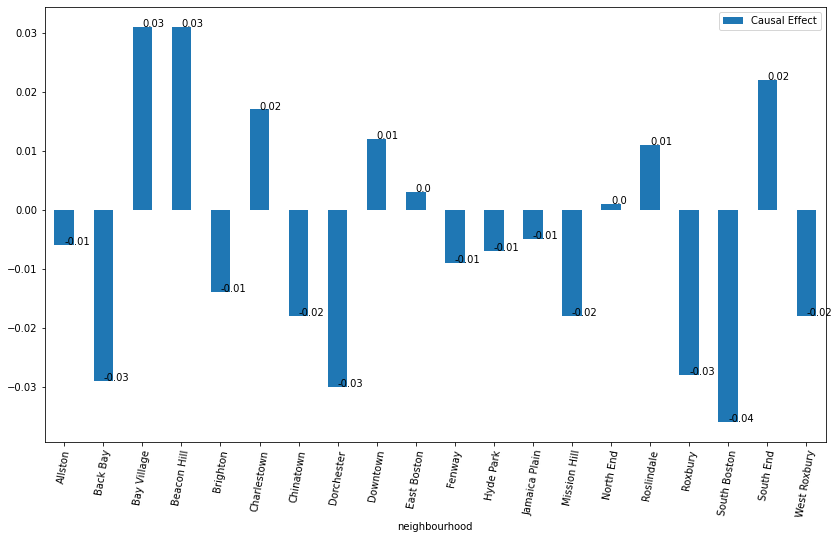

In [0]:
#new_df.hist(column='Causal Effect')
pyro.set_rng_seed(10)
fig, ax = plt.subplots(figsize=(14,8))
new_df.plot.bar(x = 'neighbourhood', y = ['Causal Effect'], rot = 80, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

*Inference:* This plot shows that if we consider all the factors in their best ranges that gave the highest ROI's with the neighbourhoods. This best neighbourhood would be **Beacon hill** as it will give the highest ROI and it is one of the most attractive places in boston also.

###  Bedrooms and Bathrooms being the same, how does no of beds affect the ROI?
$P(ROI = high | do(beds=medium), bedrooms=(1,2], bathrooms = 1.0) - P(ROI = low | do(beds=high), bedrooms=(1,2], bathrooms = 1.0)$

In [0]:
pyro.set_rng_seed(10)
bedbathmodel = pyro.condition(pyroModel, data = {"bedrooms": torch.tensor(0),"bathrooms":torch.tensor(0)})
beds_low = pyro.do(bedbathmodel, data={'beds': torch.tensor(0)})
roi_posterior = pyro.infer.Importance(beds_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
low_beds = roi_counts[1]/sum(roi_counts)

beds_high = pyro.do(bedbathmodel, data={'beds': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(beds_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
high_beds = roi_counts[1]/sum(roi_counts)

low_beds - high_beds

0.00379999999999997

We can infer from the above that more the number of beds higher the probability of a high ROI, as number of beds doesn't effect the market value and only affects the price of the listing on Airbnb.


### Price, closenessToDowntown being the same; how does minimum_nights affect the ROI?

$P(ROI = high|do(minimum_nights=low), price=medium, closenessToDowntown=far) - P(ROI = high|do(minimum_nights=high), price=medium, closenessToDowntown=far)$

In [0]:
price_downtown = pyro.condition(pyroModel, data = {"price": torch.tensor(0),"closenessToDowntown":torch.tensor(1)})

In [0]:
pyro.set_rng_seed(10)
minnights_low = pyro.do(price_downtown, data={'minimum_nights_avg_ntm': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(minnights_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
minnights_low_val = roi_counts[1]/sum(roi_counts)

minnights_high = pyro.do(price_downtown, data={'minimum_nights_avg_ntm': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(minnights_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
minnights_high_val = roi_counts[1]/sum(roi_counts)

minnights_high_val - minnights_low_val

0.019000000000000017

A lot of airbnb listings are targeted at people trying to rent out a property for a couple of months or even a year. For properties far away from the city, we wanted to check if the ROI increases when the minimum nights of stay of the listing is increased. However, we found no significance difference in the probability of achieiving a higher ROI. 

### Price being the same, how does 'accommodates' affect ROI?

$P(ROI=high| do(accomodates=high), price=medium) - P(ROI=high| do(accomodates=low), price=medium)$

In [0]:
med_price = pyro.condition(pyroModel, data = {"price": torch.tensor(0)})

In [0]:
pyro.set_rng_seed(10)
accommodates_low = pyro.do(med_price, data={'accommodates': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(accommodates_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
roi_accommodates_low = roi_counts[1]/sum(roi_counts)

accommodates_high = pyro.do(med_price, data={'accommodates': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(accommodates_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
roi_accommodates_high = roi_counts[1]/sum(roi_counts)

roi_accommodates_high - roi_accommodates_low

0.012199999999999989

The results match our intuition that more than no of people a listing accommodates, the higher its probability for a high ROI.

### Number of bedrooms being the same, how does 'accommodates' affect ROI?

$P(ROI=high|do(accommodates=high), bedrooms=medium) - P(ROI=high|do(accommodates=low), bedrooms=medium)$

In [0]:
bedrooms_med = pyro.condition(pyroModel, data = {"bedrooms": torch.tensor(0)})

In [0]:
pyro.set_rng_seed(10)
accommodates_low = pyro.do(bedrooms_med, data={'accommodates': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(accommodates_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
bedrooms_accommodates_low = roi_counts[1]/sum(roi_counts)

accommodates_high = pyro.do(bedrooms_med, data={'accommodates': torch.tensor(0)})
roi_posterior = pyro.infer.Importance(accommodates_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
bedrooms_accommodates_high = roi_counts[1]/sum(roi_counts)

bedrooms_accommodates_high - bedrooms_accommodates_low

-0.0005999999999999894

The result shows that there is a higher probability of getting a high ROI when the listing accommodates more people for the same number of bedrooms.

### Neighbourhood being the same, how does 'publicSchoolScores' affect ROI?

$P(ROI=high|do(publicSchoolScores=low), neighbourhood=downtown) - P(ROI=high|do(publicSchoolScores=high), neighbourhood=downtown)$

In [0]:
neigh_downtown = pyro.condition(pyroModel, data = {"neighbourhood": torch.tensor(5)})

In [0]:
pyro.set_rng_seed(10)
pss_low = pyro.do(neigh_downtown, data={'publicSchoolScores': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(pss_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
downtown_pss_low = roi_counts[1]/sum(roi_counts)

pss_high = pyro.do(neigh_downtown, data={'publicSchoolScores': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(pss_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
downtown_pss_high = roi_counts[1]/sum(roi_counts)

downtown_pss_low - downtown_pss_high

0.0020000000000000018

This shows that there is a higher probability of getting a high ROI when the listing is close to good public schools in Downtown. Good Public School Scores may be an indication of some confounders that our model failed to capture.

# Check the model with Zillow Property listings

The following is an Applet that was built using the Google Colab Platform, to use the applet interactively, its recommened to use it in Google Colab. The link for the same can be found at the top of the notebook

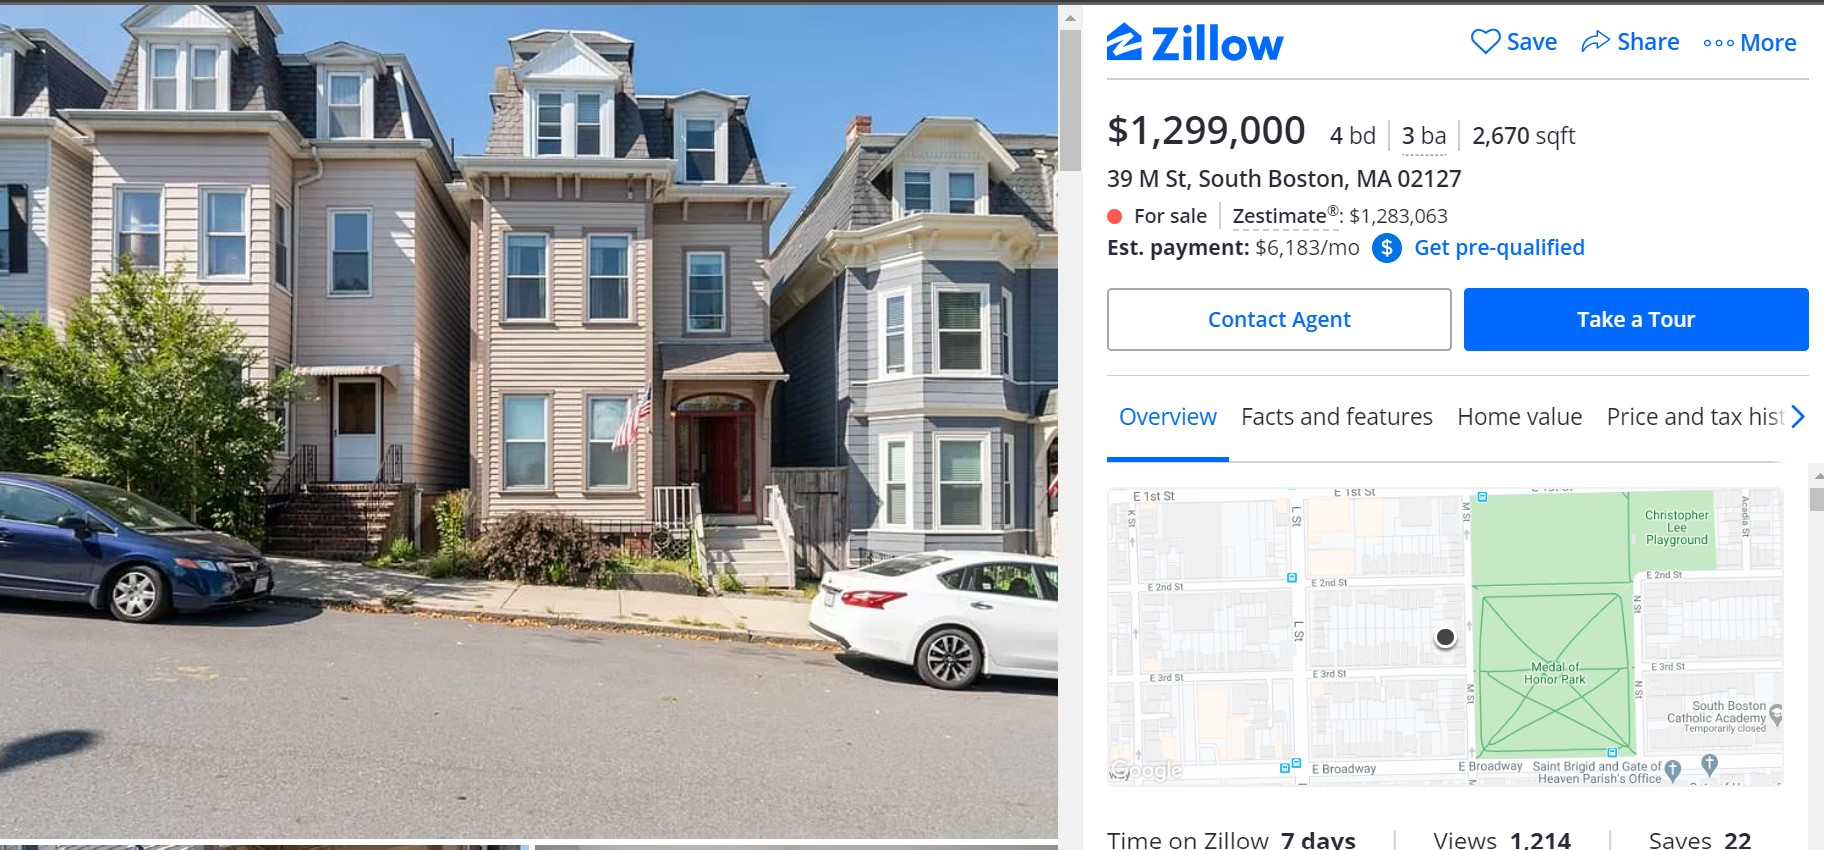

In [0]:
Image(filename='images/Zillow_1.jpg')

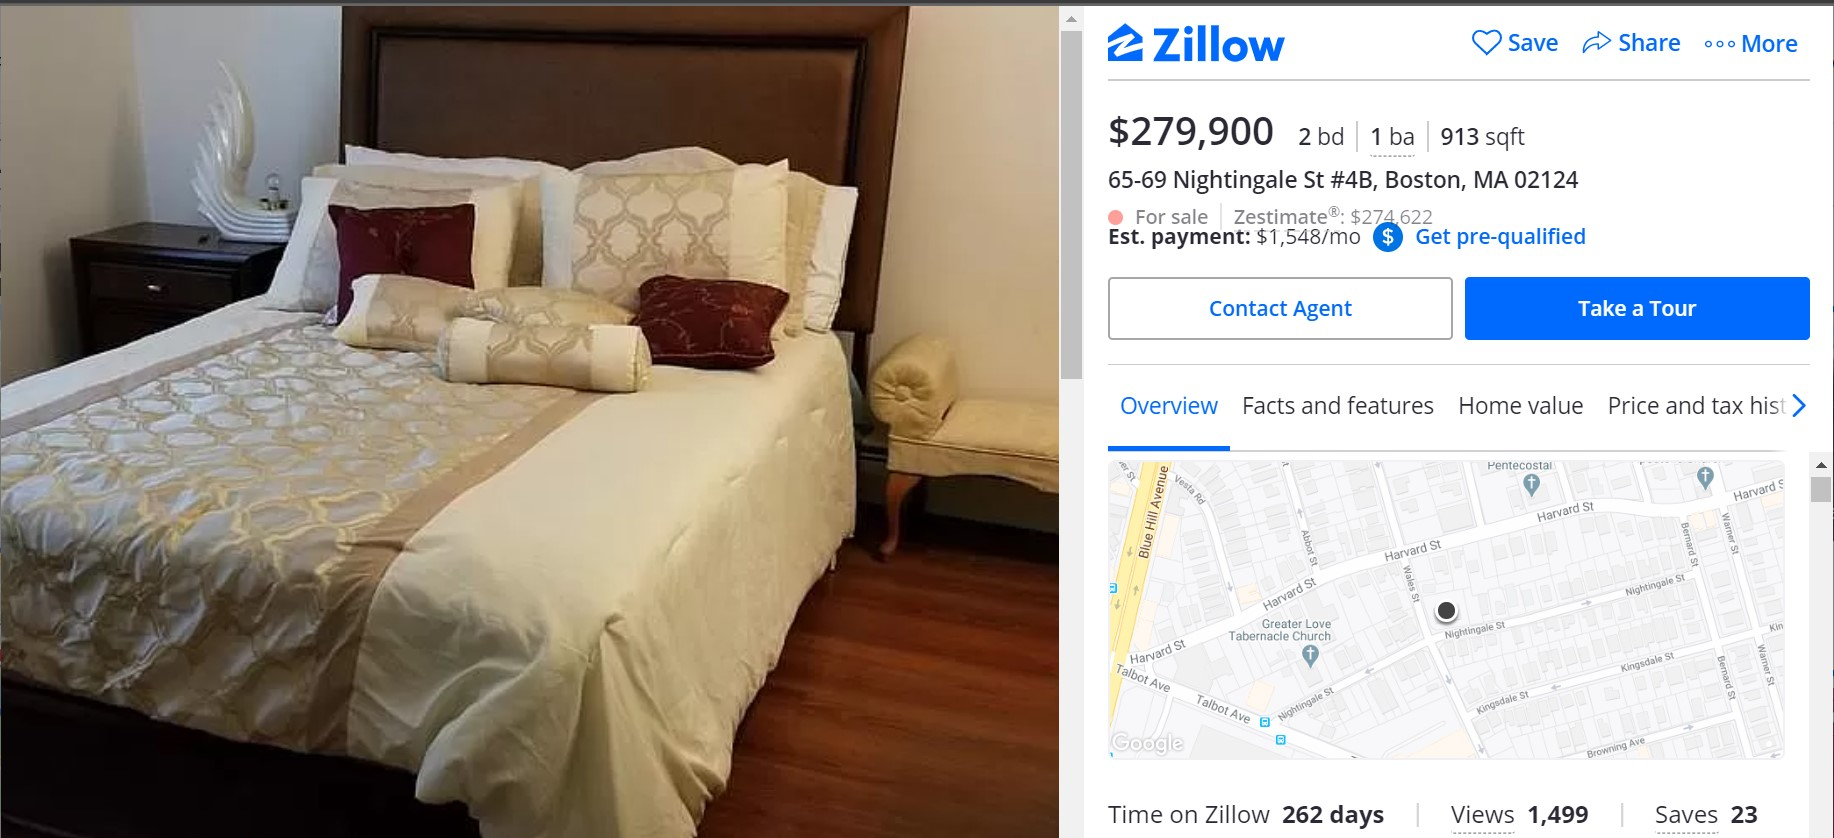

In [0]:
Image(filename='images/Zillow_2.jpg')

In [0]:
#@title ROI calculator
pyro.set_rng_seed(10)
labels['bathrooms']=  [str(x) for x in labels['bathrooms']]
bedrooms  = '[0,1]' #@param [ '[0,1]','(1,2]', '(2,6]']
bathrooms  = "2.0" #@param ['1.0', '1.5', '2.0', '2.5', '3.0']
property_type='Apartment'  #@param['Apartment', 'Condominium']
neighbourhood = 'Jamaica Plain' #@param ['Allston','Back Bay','Bay Village','Beacon Hill','Brighton','Charlestown','Chinatown','Dorchester','Downtown','East Boston','Fenway','Hyde Park','Jamaica Plain','Mission Hill','North End','Roslindale', 'Roxbury', 'South Boston', 'South End', 'West Roxbury']
MarketPrice= '[1.66e+05,5.45e+05]' #@param ['[1.66e+05,5.45e+05]','(5.45e+05,8.71e+05]', '(8.71e+05,1.15e+07]']


data = {'bedrooms':torch.tensor(labels['bedrooms'].index(bedrooms)),
        'bathrooms':torch.tensor(labels['bathrooms'].index(bathrooms)),
        'property_type':torch.tensor(labels['property_type'].index(property_type)),
        'neighbourhood':torch.tensor(labels['neighbourhood'].index(neighbourhood)),
        'Zestimate':torch.tensor(labels['Zestimate'].index(MarketPrice))}

#Computing P(roi=high|do(publicSchoolScores=high)) using do operator
high = pyro.do(pyroModel, data=data)
roi_posterior = pyro.infer.Importance(high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
high = roi_counts[1]/sum(roi_counts)
low = roi_counts[2]/sum(roi_counts)

print("Probability of making a profit:",round(high*100,3),'%')
print("Probability of making a loss  :",round(low*100,3),'%')

Probability of making a profit: 38.26 %
Probability of making a loss  : 27.98 %


### Compare two properties

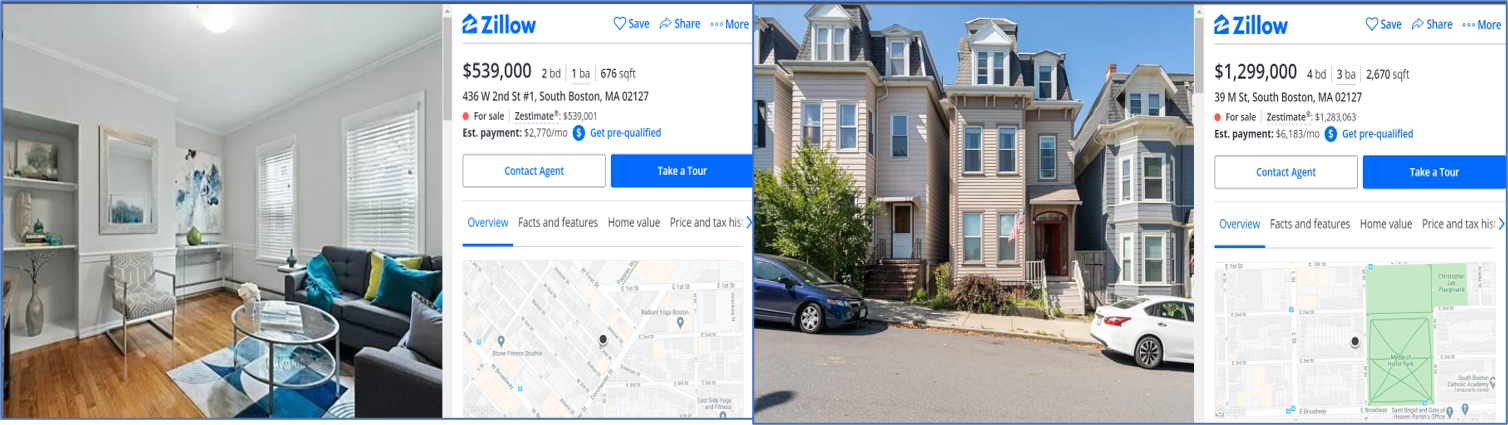

In [0]:
Image(filename='images/zillow_south_boston.png')

In [0]:
#@title Compare two properties

#@markdown Properties of first property
pyro.set_rng_seed(10)
bedrooms1  = '(2,6]' #@param [ '[0,1]','(1,2]', '(2,6]']
bathrooms1  = "3.0" #@param ['1.0', '1.5', '2.0', '2.5', '3.0']
property_type1='Condominium'  #@param['Apartment', 'Condominium']
neighbourhood1 = 'South Boston' #@param ['Allston','Back Bay','Bay Village','Beacon Hill','Brighton','Charlestown','Chinatown','Dorchester','Downtown','East Boston','Fenway','Hyde Park','Jamaica Plain','Mission Hill','North End','Roslindale', 'Roxbury', 'South Boston', 'South End', 'West Roxbury']
MarketPrice1= '(8.71e+05,1.15e+07]' #@param ['[1.66e+05,5.45e+05]','(5.45e+05,8.71e+05]', '(8.71e+05,1.15e+07]']

data1 = {'bedrooms':torch.tensor(labels['bedrooms'].index(bedrooms1)),
        'bathrooms':torch.tensor(labels['bathrooms'].index(bathrooms1)),
        'property_type':torch.tensor(labels['property_type'].index(property_type1)),
        'neighbourhood':torch.tensor(labels['neighbourhood'].index(neighbourhood1)),
        'Zestimate':torch.tensor(labels['Zestimate'].index(MarketPrice1))}

#@markdown Properties of second property
bedrooms2  = '(1,2]' #@param [ '[0,1]','(1,2]', '(2,6]']
bathrooms2  = "1.0" #@param ['1.0', '1.5', '2.0', '2.5', '3.0']
property_type2='Condominium'  #@param['Apartment', 'Condominium']
neighbourhood2 = 'South Boston' #@param ['Allston','Back Bay','Bay Village','Beacon Hill','Brighton','Charlestown','Chinatown','Dorchester','Downtown','East Boston','Fenway','Hyde Park','Jamaica Plain','Mission Hill','North End','Roslindale', 'Roxbury', 'South Boston', 'South End', 'West Roxbury']
MarketPrice2= '(5.45e+05,8.71e+05]' #@param ['[1.66e+05,5.45e+05]','(5.45e+05,8.71e+05]', '(8.71e+05,1.15e+07]']

data2 = {'bedrooms':torch.tensor(labels['bedrooms'].index(bedrooms2)),
        'bathrooms':torch.tensor(labels['bathrooms'].index(bathrooms2)),
        'property_type':torch.tensor(labels['property_type'].index(property_type2)),
        'neighbourhood':torch.tensor(labels['neighbourhood'].index(neighbourhood2)),
         'Zestimate':torch.tensor(labels['Zestimate'].index(MarketPrice2))}



#Computing P(roi=high|do(first)) using do operator
first = pyro.do(pyroModel, data=data1)
roi_posterior = pyro.infer.Importance(first, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
first_high = roi_counts[1]/sum(roi_counts)
first_low = roi_counts[2]/sum(roi_counts)


second = pyro.do(pyroModel, data=data2)
roi_posterior = pyro.infer.Importance(second, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
second_high = roi_counts[1]/sum(roi_counts)
second_low  = roi_counts[2]/sum(roi_counts)

print("Probability of making profit 1st Property:",round(first_high*100,3),'%')
print("Probability of making profit 2nd Property:",round(second_high*100,3),'%')
print("\n")
print("Probability of making loss 1st Property:",round(first_low*100,3),'%')
print("Probability of making loss 2nd Property:",round(second_low*100,3),'%')




Probability of making profit 1st Property: 30.02 %
Probability of making profit 2nd Property: 32.82 %


Probability of making loss 1st Property: 39.64 %
Probability of making loss 2nd Property: 31.84 %


## Steps to improve the model

* We believe the adding more data would results in better results
* Adding more detailed information on taxing data, as we were not able to add the exact property taxes for each house
* Add more on topics like, crime in the area, proximity to universities etc.

